In [6]:
# Autoreload packages that are modified
%load_ext autoreload
%autoreload 2

from datetime import datetime, timedelta
import glob
import os
import sys
import time

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

cwd = os.getcwd()
sys.path.append(f"{cwd}/forecast_rodeo")
sys.path.append(f"{cwd}/forecast_rodeo/src/experiments")
from experiments_util import get_target_date
from stepwise_util import default_stepwise_candidate_predictors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
#https://stackoverflow.com/questions/43147983/could-not-create-cudnn-handle-cudnn-status-internal-error
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [12]:
target = "contest_tmp2m" # "contest_precip" or "contest_tmp2m"
target_horizon = "34w" # "34w" or "56w"

data_path = os.path.expanduser("forecast_rodeo/results/regression/shared")
data_matrices_folder = f"{target}_{target_horizon}"
fs = glob.glob(f"{data_path}/{data_matrices_folder}/*.h5")
print(fs)
lat_lon_date_data_file = fs[0]
date_data_file = fs[1]

['forecast_rodeo/results/regression/shared/contest_tmp2m_34w/lat_lon_date_data-contest_tmp2m_34w.h5', 'forecast_rodeo/results/regression/shared/contest_tmp2m_34w/date_data-contest_tmp2m_34w.h5']


## Define dates of interest for prediction

In [13]:
submission_dates = [datetime(y,4,18)+timedelta(14*i) for y in range(2011,2018) for i in range(26)]
submission_dates = ['{}{:02d}{:02d}'.format(date.year, date.month, date.day) for date in submission_dates]
target_dates = [get_target_date(submission_date_str, target_horizon) for submission_date_str in submission_dates]
target_dates = ['{}{:02d}{:02d}'.format(date.year, date.month, date.day) for date in target_dates]

for submission_date, target_date in zip(submission_dates, target_dates):
    print(f"submission date: {submission_date}, target date: {target_date}")
    
# get data array names we care about
initial_candidate_x_cols = default_stepwise_candidate_predictors(target, target_horizon, hindcast=False)
print(initial_candidate_x_cols)

submission date: 20110418, target date: 20110502
submission date: 20110502, target date: 20110516
submission date: 20110516, target date: 20110530
submission date: 20110530, target date: 20110613
submission date: 20110613, target date: 20110627
submission date: 20110627, target date: 20110711
submission date: 20110711, target date: 20110725
submission date: 20110725, target date: 20110808
submission date: 20110808, target date: 20110822
submission date: 20110822, target date: 20110905
submission date: 20110905, target date: 20110919
submission date: 20110919, target date: 20111003
submission date: 20111003, target date: 20111017
submission date: 20111017, target date: 20111031
submission date: 20111031, target date: 20111114
submission date: 20111114, target date: 20111128
submission date: 20111128, target date: 20111212
submission date: 20111212, target date: 20111226
submission date: 20111226, target date: 20120109
submission date: 20120109, target date: 20120123
submission date: 201

### Load temperature data

In [5]:
all_frames_path = os.path.expanduser("~/code/ssr/forecast_rodeo/data/dataframes")
gt_temp_file = f"{all_frames_path}/gt-contest_tmp2m-14d-1979-2018.h5"

temp2m_df = pd.read_hdf(gt_temp_file)
print(temp2m_df.columns)

Index(['lat', 'lon', 'start_date', 'tmp2m', 'tmp2m_sqd', 'tmp2m_std'], dtype='object')


In [6]:
# how to get all the unique lat lon pairs
all_lat_lon_df = temp2m_df[['lat', 'lon']]
print(all_lat_lon_df)
lat_lons_of_interest = []
for row in all_lat_lon_df.itertuples():
    if (row.lat, row.lon) not in lat_lons_of_interest:
        lat_lons_of_interest.append((row.lat, row.lon))
print(len(lat_lons_of_interest))

          lat    lon
0        27.0  261.0
1        27.0  261.0
2        27.0  261.0
3        27.0  261.0
4        27.0  261.0
...       ...    ...
7395427  49.0  262.0
7395428  49.0  262.0
7395429  49.0  262.0
7395430  49.0  262.0
7395431  49.0  262.0

[7395432 rows x 2 columns]
514


In [6]:
lat_oi, lon_oi = (37.0, 238.0)
one_lat_lon_temp2m_df = temp2m_df.loc[(temp2m_df.lat == lat_oi) & (temp2m_df.lon == lon_oi)]
print(one_lat_lon_temp2m_df)
one_lat_lon_temp2m_np = one_lat_lon_temp2m_df.to_numpy()
idxs = [i for i in range(len(one_lat_lon_temp2m_df))]

          lat    lon start_date      tmp2m   tmp2m_sqd  tmp2m_std
2186976  37.0  238.0 1979-01-01   9.685465   98.091537   2.069615
2186977  37.0  238.0 1979-01-02  10.077033  103.413493   1.366344
2186978  37.0  238.0 1979-01-03  10.206581  105.486807   1.145651
2186979  37.0  238.0 1979-01-04  10.092230  103.653831   1.341907
2186980  37.0  238.0 1979-01-05  10.038739  102.782099   1.416269
...       ...    ...        ...        ...         ...        ...
2201359  37.0  238.0 2018-05-19  15.621224  247.664573   1.908387
2201360  37.0  238.0 2018-05-20  16.091940  264.357756   2.325344
2201361  37.0  238.0 2018-05-21  16.508874  278.730763   2.487540
2201362  37.0  238.0 2018-05-22  16.654487  283.447718   2.464908
2201363  37.0  238.0 2018-05-23  16.728271  285.691493   2.420009

[14388 rows x 6 columns]


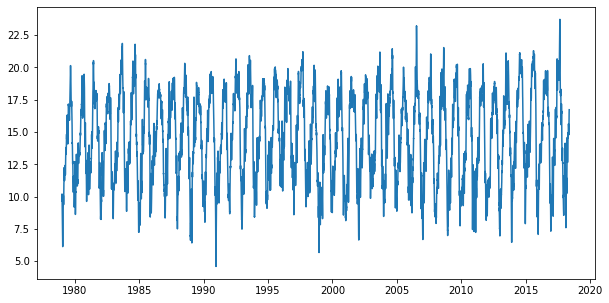

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(one_lat_lon_temp2m_np[:, 2], one_lat_lon_temp2m_np[:, 3])

          lat    lon start_date      tmp2m   tmp2m_sqd  tmp2m_std
2194646  37.0  238.0 2000-01-01   9.409845   91.656473   1.763887
2194647  37.0  238.0 2000-01-02   9.754491  100.402238   2.291756
2194648  37.0  238.0 2000-01-03  10.121112  107.740073   2.302861
2194649  37.0  238.0 2000-01-04  10.509314  113.328354   1.697843
2194650  37.0  238.0 2000-01-05  10.959415  123.751965   1.908716
...       ...    ...        ...        ...         ...        ...
2198294  37.0  238.0 2009-12-27   9.633540   94.482811   1.295271
2198295  37.0  238.0 2009-12-28   9.465441   91.320222   1.313641
2198296  37.0  238.0 2009-12-29   9.526010   92.395743   1.284867
2198297  37.0  238.0 2009-12-30   9.928600  100.490484   1.383252
2198298  37.0  238.0 2009-12-31  10.104965  104.698383   1.608744

[3653 rows x 6 columns]


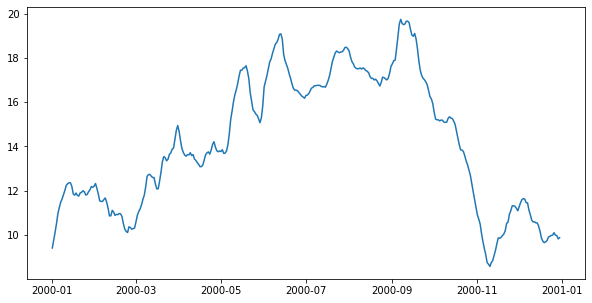

In [8]:
one_lat_lon_10yr_temp2m_df = one_lat_lon_temp2m_df.loc[one_lat_lon_temp2m_df.start_date.dt.year >= 2000]
one_lat_lon_10yr_temp2m_df = one_lat_lon_10yr_temp2m_df.loc[one_lat_lon_10yr_temp2m_df.start_date.dt.year < 2010]
print(one_lat_lon_10yr_temp2m_df)

plt.figure(figsize=(10, 5))
one_lat_lon_10yr_temp2m_np = one_lat_lon_10yr_temp2m_df.to_numpy()
plt.plot(one_lat_lon_10yr_temp2m_np[:365, 2], one_lat_lon_10yr_temp2m_np[:365, 3])

In [9]:
num_forecast_steps = 30 # one year
temp_train = one_lat_lon_10yr_temp2m_np[:-num_forecast_steps, 3]
dates_train = one_lat_lon_10yr_temp2m_np[:-num_forecast_steps, 2]
temp_test = one_lat_lon_10yr_temp2m_np[-num_forecast_steps:, 3]
dates_test = one_lat_lon_10yr_temp2m_np[-num_forecast_steps:, 2]

## TF Structural Time Series

In [10]:
tmp_by_date = temp_train.astype(np.float32)

trend = tfp.sts.LocalLinearTrend(observed_time_series=tmp_by_date)
seasonal = tfp.sts.Seasonal(
    num_seasons=4, 
    observed_time_series=tmp_by_date,
    num_steps_per_season=91, 
    name='seasonal'
)
monthly = tfp.sts.Seasonal(
    num_seasons=12,
    observed_time_series=tmp_by_date,
    num_steps_per_season=[31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
    drift_scale_prior=tfd.LogNormal(loc=-1., scale=0.1),
    initial_effect_prior=tfd.Normal(loc=0., scale=5.),
    name='month_of_year',
)
model = tfp.sts.Sum([trend, monthly, seasonal], observed_time_series=tmp_by_date)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model)

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [ ]:
#title Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 80 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_log_prob(
        observed_time_series=tmp_by_date),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

start = time.time()
elbo_loss_curve = train()
end = time.time()
print(f"took {end - start} seconds")

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_temp_ = variational_posteriors.sample(50)


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [121]:
print("Inferred parameters:")
for param in model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_temp_[param.name], axis=0),
                              np.std(q_samples_temp_[param.name], axis=0)))


Inferred parameters:
observation_noise_scale: 0.0029372740536928177 +- 0.0006944669294171035
LocalLinearTrend/_level_scale: 0.06354504823684692 +- 0.0006463337340392172
LocalLinearTrend/_slope_scale: 0.15191195905208588 +- 0.0028152752202004194
month_of_year/_drift_scale: 0.2222338318824768 +- 0.015035981312394142
seasonal/_drift_scale: 0.0272113848477602 +- 0.015110818669199944


In [122]:
temp_forecast_dist = tfp.sts.forecast(
    model,
    observed_time_series=tmp_by_date,
    parameter_samples=q_samples_temp_,
    num_steps_forecast=num_forecast_steps)


In [123]:
num_samples=20

temp_forecast_mean, temp_forecast_scale, temp_forecast_samples = (
    temp_forecast_dist.mean().numpy()[..., 0],
    temp_forecast_dist.stddev().numpy()[..., 0],
    temp_forecast_dist.sample(num_samples).numpy()[..., 0])


In [124]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
    """Plot a forecast distribution against the 'true' time series."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast
    print(num_steps)
    print(num_steps_forecast)
    print(num_steps_train)
    
    ax.plot(x, y, lw=2, color=c1, label='ground truth')

    forecast_steps = x[num_steps_train:num_steps_train+num_steps_forecast]

    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

    ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
    ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

    ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
    yrange = ymax-ymin
    ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
    ax.set_title("{}".format(title))
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()

    return fig, ax


368
30
338


<Figure size 720x360 with 0 Axes>

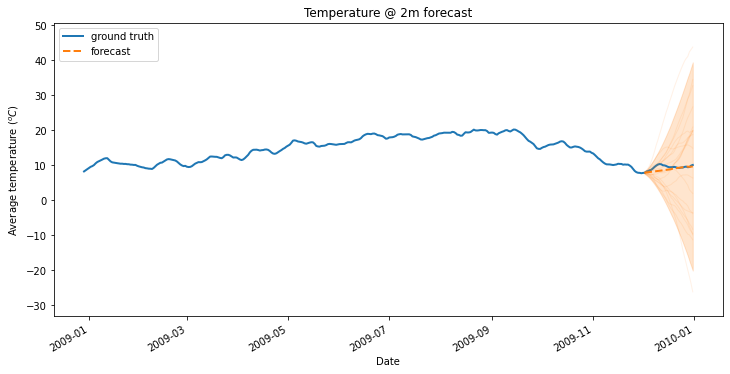

In [125]:
plt.figure(figsize=(10, 5))
fig, ax = plot_forecast(
    one_lat_lon_10yr_temp2m_np[365*9:, 2], one_lat_lon_10yr_temp2m_np[365*9:, 3],
    temp_forecast_mean, temp_forecast_scale, temp_forecast_samples,
    title="Temperature @ 2m forecast")
# ax.axvline(one_lat_lon_10yr_temp2m_np[365*9:, 2][-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Average temperature ($^oC$)")
ax.set_xlabel("Date")
fig.autofmt_xdate()


In [126]:
component_dists = tfp.sts.decompose_by_component(
    model,
    observed_time_series=tmp_by_date,
    parameter_samples=q_samples_temp_)

temp_component_means_, temp_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

In [127]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
    import collections
    """Plot the contributions of posterior components in a single figure."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]

    axes_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig = plt.figure(figsize=(12, 5 * num_components))
    for i, component_name in enumerate(component_means_dict.keys()):
        component_mean = component_means_dict[component_name]
        component_stddev = component_stddevs_dict[component_name]

        ax = fig.add_subplot(num_components,1,1+i)
        ax.plot(dates, component_mean, lw=2)
        ax.fill_between(dates,
                         component_mean-2*component_stddev,
                         component_mean+2*component_stddev,
                         color=c2, alpha=0.5)
        ax.set_title(component_name)
        if x_locator is not None:
            ax.xaxis.set_major_locator(x_locator)
            ax.xaxis.set_major_formatter(x_formatter)
        axes_dict[component_name] = ax
    fig.autofmt_xdate()
    fig.tight_layout()
    return fig, axes_dict

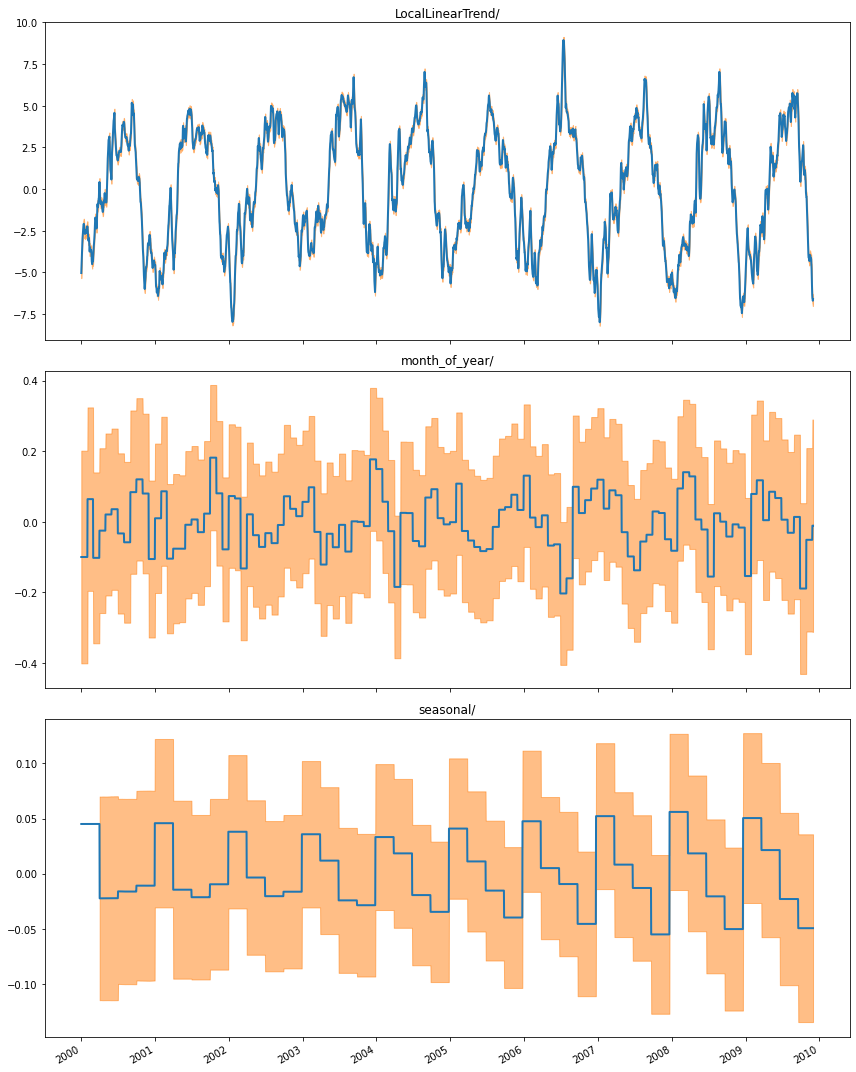

In [128]:
_ = plot_components(one_lat_lon_10yr_temp2m_np[:-num_forecast_steps, 2], temp_component_means_, temp_component_stddevs_,)


## Lat/Lon/Date/data

In [ ]:
print(f"reading data from {lat_lon_date_data_file}")

lld_df = pd.read_hdf(lat_lon_date_data_file)
print(lld_df)

In [ ]:
first_year = 1979 # first_year = 1948 if gt_col == "precip" else 1979
gt_col = target.split('_')[-1]
# clim_col = f"{gt_col}_clim"
# anom_col = f"{gt_col}_anom" # 'tmp2m_anom' or 'precip_anom'
base_col = 'zeros'

relevant_cols = set(initial_candidate_x_cols+[base_col,'start_date','lat','lon'])

data = lld_df.loc[lld_df.start_date.dt.year >= first_year]
data = data.loc[lld_df.start_date.dt.year <= 2018]
print(data)
# data = pd.merge(data, date_data.loc[date_data.start_date.dt.year >= first_train_year,
#                                     date_data.columns.isin(relevant_cols)],
#                 on="start_date", how="left")

In [ ]:
yr_min = 1000000
yr_max = 0
for date in climatology["start_date"]:
    if date.year > yr_max:
        yr_max = date.year
    if date.year < yr_min:
        yr_min = date.year
print(yr_max)
print(yr_min)

In [ ]:
tmp = np.array(data.tmp2m_shift58)
print(np.sum(np.isnan(tmp)))
print(np.sum(np.invert(np.isnan(tmp))))